In [1]:
import torch


In [11]:
t = torch.tensor([[[1, 2, 3], [4, 5, 6]]])
print(t)
print(t.reshape(-1, 6))

tensor([[[1, 2, 3],
         [4, 5, 6]]])
tensor([[1, 2, 3, 4, 5, 6]])


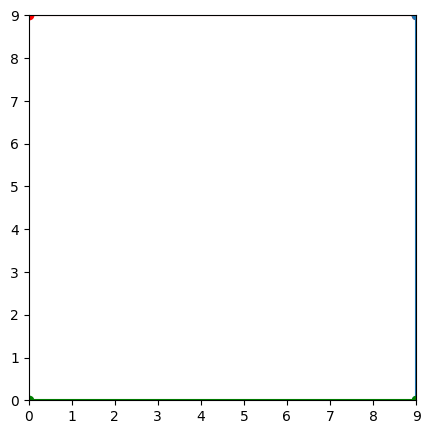

In [24]:
import matplotlib.pyplot as plt

def rotate_point(x, y, n, max_val):
    # Perform the rotation n times
    for _ in range(n % 4):
        x, y = y, max_val - x

    return x, y

max_val = 9
x, y = 0, 9  # Replace these values with your point coordinates
n = 1         # Number of 90-degree counterclockwise rotations

x1, y1 = rotate_point(x, y, n, max_val)
x2, y2 = rotate_point(x1, y1, n, max_val)
x3, y3 = rotate_point(x2, y2, n, max_val)


plt.figure(figsize=(5, 5))
plt.plot([x, x1], [y, y1], 'ro-')
plt.plot([x1, x2], [y1, y2], 'o-')
plt.plot([x2, x3], [y2, y3], 'go-')
plt.axis([0, max_val, 0, max_val])
plt.show()
